### Denoising Autoencoder

Add gaussian noise to the 60,000 images of the MNIST training dataset, and construct an encoder that encodes each image to some latent space of 100 dimensions. For the decoder, upsample using the fractionally strided convolutions (deconvolutions) to reconstruct the image. Minimize the reconstruction loss and test on the test dataset.

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets(".", validation_size=0)

target_img = tf.placeholder(tf.float32, [None,28,28,1])
input_img = tf.placeholder(tf.float32, [None,28,28,1])

# with tf.device('/gpu:0'):
### Encoder ###
conv1 = tf.layers.conv2d(input_img, 32, [3, 3], padding="same", activation=tf.nn.relu)
# 28*28*32
conv2 = tf.layers.conv2d(conv1, 32, [3, 3], padding="same", activation=tf.nn.relu)
# 28*28*32
conv3 = tf.layers.conv2d(conv2, 16, [3, 3], padding="same", activation=tf.nn.relu)
# 28*28*16

encoder_output = tf.contrib.layers.flatten(conv3)
# add one fully connected layer to reduce the dimensions down to 100
dense = tf.layers.dense(inputs=encoder_output,units=100,activation=tf.nn.relu)
latent_iuput = tf.reshape(dense,[-1,10,10,1])

### Decoder ###
deconv1 = tf.layers.conv2d_transpose(latent_iuput, 16, [7,7], padding='valid', activation=tf.nn.relu)
# 16*16*16
deconv2 = tf.layers.conv2d_transpose(deconv1, 32, [5,5], padding='valid', activation=tf.nn.relu)
# 20*20*32
deconv3 = tf.layers.conv2d_transpose(deconv2, 32, [5,5], padding='valid', activation=tf.nn.relu)
# 24*24*32
deconv4 = tf.layers.conv2d_transpose(deconv3, 32, [5,5], padding='valid', activation=tf.nn.relu)
# 28*28*32
deconv5 = tf.layers.conv2d_transpose(deconv3, 1, [5,5], padding='valid', activation=None)
# 28*28*1

# now get 28*28*1 back 
decoder_output = tf.nn.sigmoid(deconv5, name='decoder_output')

L = tf.sqrt(tf.reduce_sum(tf.square(target_img-decoder_output)))
# euclidean distance loss

optim = tf.train.AdamOptimizer(0.001).minimize(L)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

num_iter = 10
batch_size = 128

noise_factor = 0.5

for ep in range(num_iter):
    for i in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        batch_img = batch[0].reshape([-1,28,28,1])

        noise = noise_factor*np.random.randn(*batch_img.shape)
        noisy_img = np.clip((batch_img+noise),0.,1.)

        _, l = sess.run([optim,L], feed_dict={target_img:batch_img, input_img:noisy_img})

        print("Epoch: {}/{}...".format(ep+1, num_iter),
              "Training loss: {:.4f}".format(l))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

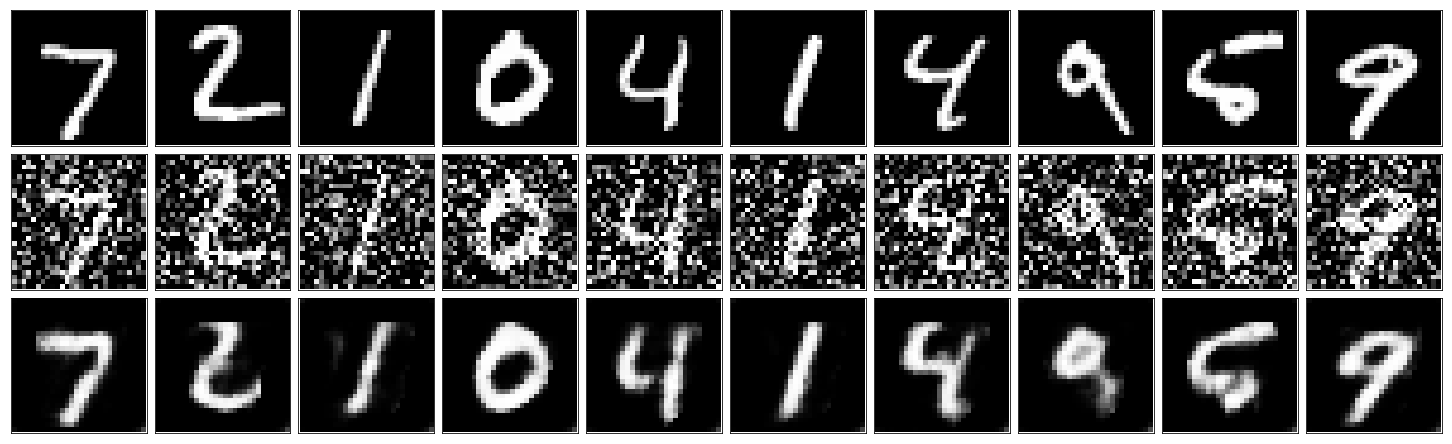

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,6))

test_samples = mnist.test.images[:10]
noise = noise_factor*np.random.randn(*test_samples.shape)
noisy_test_samples = np.clip((test_samples+noise),0.,1.)

reconstructed = sess.run(decoder_output, feed_dict={input_img: noisy_test_samples.reshape([10, 28, 28, 1])})

for images, row in zip([test_samples,noisy_test_samples,reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)